Holt-Winters Forecasting in Python

credit: https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/

This three part write up [Part II Part III] is my attempt at a down-to-earth explanation (and Python code) of the Holt-Winters method for those of us who while hypothetically might be quite good at math, still try to avoid it at every opportunity. I had to dive into this subject while tinkering on tgres (which features a Golang implementation). And having found it somewhat complex (and yet so brilliantly simple), figured that it’d be good to share this knowledge, and in the process, to hopefully solidify it in my head as well.

Triple Exponential Smoothing, also known as the Holt-Winters method, is one of the many methods or algorithms that can be used to forecast data points in a series, provided that the series is “seasonal”, i.e. repetitive over some period.

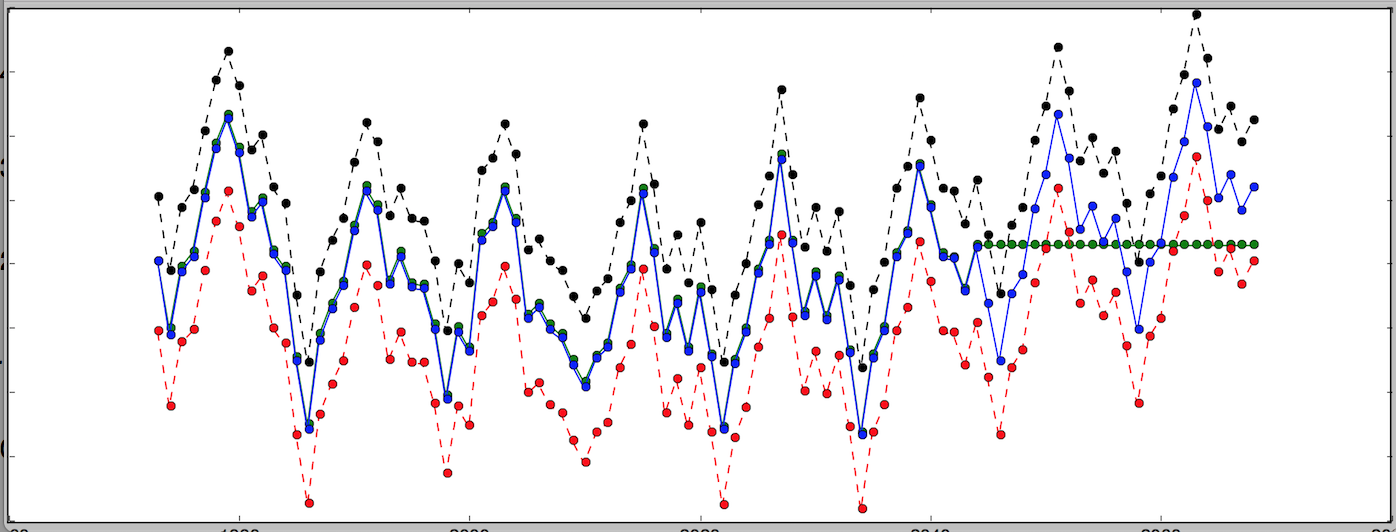

In [1]:
from IPython.display import Image

path = r"P:\NWPERM\Learn\Python Study Group\ImagesPython"

Image(filename = path + "\\hw00.png", width = 900, height= 1000)

## A little history

Еxponential smoothing in some form or another dates back to the work of Siméon Poisson (1781-1840), while its application in forecasting appears to have been pioneered over a century later in 1956 by Robert Brown (1923–2013) in his publication Exponential Smoothing for Predicting Demand, (Cambridge, Massachusetts). [Based on the URL it seems Brown was working on forecasting tobacco demand?]

In 1957 an MIT and University of Chicago graduate, professor Charles C Holt (1921-2010) was working at CMU (then known as CIT) on forecasting trends in production, inventories and labor force. It appears that Holt and Brown worked independently and knew not of each-other’s work. Holt published a paper “Forecasting trends and seasonals by exponentially weighted moving averages” (Office of Naval Research Research Memorandum No. 52, Carnegie Institute of Technology) describing double exponential smoothing. Three years later, in 1960, a student of Holts (?) Peter R. Winters improved the algorithm by adding seasonality and published Forecasting sales by exponentially weighted moving averages (Management Science 6, 324–342), citing Dr. Holt’s 1957 paper as earlier work on the same subject. This algorithm became known as triple exponential smoothing or the Holt-Winters method, the latter probably because it was described in a 1960 Prentice-Hall book “Planning Production, Inventories, and Work Force” by Holt, Modigliani, Muth, Simon, Bonini and Winters - good luck finding a copy!

Curiously, I’ve not been able to find any personal information on Peter R. Winters online. If you find anything, please let me know, I’ll add a reference here.

In 2000 the Holt-Winters method became well known in the ISP circles at the height of the .com boom when Jake D. Brutlag (then of WebTV) published Aberrant Behavior Detection in Time Series for Network Monitoring (Proceedings of the 14th Systems Administration Conference, LISA 2000). It described how an open source C implementation [link to the actual commit] of a variant of the Holt-Winters seasonal method, which he contributed as a feature to the very popular at ISPs RRDTool, could be used to monitor network traffic.

In 2003, a remarkable 40+ years since the publication of Winters paper, professor James W Taylor of Oxford University extended the Holt-Winters method to multiple seasonalities (i.e. n-th exponential smoothing) and published Short-term electricity demand forecasting using double seasonal exponential smoothing (Journal of Operational Research Society, vol. 54, pp. 799–805). (But we won’t cover Taylors method here).

In 2011 the RRDTool implementation contributed by Brutlag was ported to Graphite by Matthew Graham thus making it even more popular in the devops community.

So… how does it work?

## Single Exponential Smoothing

Here is where things get interesting. Imagine a weighted average where we consider all of the data points, while assigning exponentially smaller weights as we go back in time. For example if we started with 0.9, our weights would be (going back in time):

0.91,0.92,0.93,0.94,0.95,0.96...or: 0.9,0.81,0.729,0.6561,0.59049,0.531441,...
…eventually approaching the big old zero. In some way this is very similar to the weighted average above, only the weights are dictated by math, decaying uniformly. The smaller the starting weight, the faster it approaches zero.

Only… there is a problem: weights do not add up to 1. The sum of the first 3 numbers alone is already 2.439! (Exercise for the reader: what number does the sum of the weights approach and why?)

What earned Poisson, Holts or Roberts a permanent place in the history of Mathematics is solving this with a succinct and elegant formula:

y^x=α⋅yx+(1−α)⋅y^x−1
If you stare at it just long enough, you will see that the expected value y^x is the sum of two products: α⋅yx and (1−α)⋅y^x−1. You can think of α (alpha) as a sort of a starting weight 0.9 in the above (problematic) example. It is called the smoothing factor or smoothing coefficient (depending on who wrote your text book).

So essentially we’ve got a weighted moving average with two weights: α and 1−α. The sum of α and 1−α is 1, so all is well.

Now let’s zoom in on the right side of the sum. Cleverly, 1−α is multiplied by the previous expected value y^x−1. Which, if you think about it, is the result of the same formula, which makes the expression recursive (and programmers love recursion), and if you were to write it all out on paper you would quickly see that (1−α) is multiplied by itself again and again all the way to beginning of the series, if there is one, infinitely otherwise. And this is why this method is called exponential.

Another important thing about α is that its value dictates how much weight we give the most recent observed value versus the last expected. It’s a kind of a lever that gives more weight to the left side when it’s higher (closer to 1) or the right side when it’s lower (closer to 0).

Perhaps α would be better referred to as memory decay rate: the higher the α, the faster the method “forgets”.

Why is it called “smoothing”?
To the best of my understanding this simply refers to the effect these methods have on a graph if you were to plot the values: jagged lines become smoother. Moving average also has the same effect, so it deserves the right to be called smoothing just as well.

In [10]:
# given a series and alpha (memory decay rate), return series of smoothed points
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha*series[n] + (1 - alpha)*result[n-1])
    return result

### prediction method

In [3]:
#simple average
def average(series):
    return float(sum(series))/len(series)

In [4]:
#moving average
def moving_average(series, n):
    return average(series[-n:])

In [5]:
#average
def average(series, n = None):
    if n is None:
        return average(series, len(series))
    return float(sum(series[-n:]))/n

In [6]:
series = [3,10,12,13,12,10,12]

In [7]:
average(series, 4)

11.75

In [8]:
alpha1 = exponential_smoothing(series, 0.1)

In [9]:
alpha1

[3, 3.7, 4.53, 5.377, 6.0393, 6.43537, 6.991833]

In [9]:
predicted = average(alpha1, 4)

In [10]:
alpha1.append(predicted)

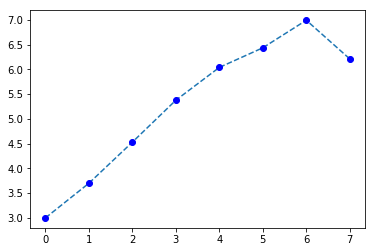

In [11]:
import matplotlib.pyplot as plt
plt.plot(alpha1, '--', alpha1, 'bo')
plt.show()

## Level

Expected value has another name, which, again varies depending on who wrote the text book: baseline, intercept (as in Y-intercept) or level. We will stick with “level” here.

So level is that one predicted point that we learned how to calculate in Part I. But because now it’s going to be only part of calculation of the forcast, we can no longer refer to it as y^ and will instead use ℓ.

## Trend or Slope

You should be familiar with slope from your high school algebra class. What you might be a little rusty on is how to calculate it, which is important, because a series slope has an interesting characteristic. Slope is:

m=Δy/Δx
where Δy is the difference in the y coordinates and Δx is the difference in the x coordinates, respectively, between two points. While in real algebraic problems Δx could be anything, in a series, from one point to the next, it is always 1. Which means that for a series, slope between two adjacent points is simply Δy1 or Δy, or:

b=yx−yx−1
Where b is trend. To the best of my understanding terms “trend” and “slope” are interchangeable. In forecasting parlance “trend” is more common, and in math notation forecasters refer to it as b rather than m.

ℓx=αyx+(1−α)(ℓx−1+bx−1)   level
bx=β(ℓx−ℓx−1)+(1−β)bx−1   trend
y^x+1=ℓx+bx               forecast            

The first equation is from Part I, only now we’re using ℓ instead of y^ and on the right side the expected value becomes the sum of level end trend.

The second equation introduces β, the trend factor (or coefficient). As with α, some values of β work better than others depending on the series.

Similarly to single exponential smoothing, where we used the first observed value as the first expected, we can use the first observed trend as the first expected. Of course we need at least two points to compute the initial trend.

Because we have a level and a trend, this method can forecast not one, but two data points. In Python:

In [12]:
# given a series and alpha, return series of smoothed points
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # we are forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1 - alpha)*(level + trend)
        trend = beta*(level - last_level) + (1- beta)*trend
        result.append(level + trend)
    return result

In [13]:
des = double_exponential_smoothing(series, 0.9, 0.9)

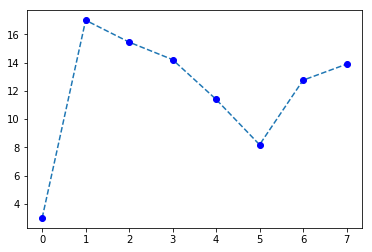

In [14]:
plt.plot(des, '--', des, 'bo')
plt.show()

### Season
If a series appears to be repetitive at regular intervals, such an interval is referred to as a season, and the series is said to be seasonal. Seasonality is required for the Holt-Winters method to work, non-seasonal series (e.g. stock prices) cannot be forecasted using this method (would be nice though if they could be).

### Season Length
Season length is the number of data points after which a new season begins. We will use L to denote season length.

### Seasonal Component
The seasonal component is an additional deviation from level + trend that repeats itself at the same offset into the season. There is a seasonal component for every point in a season, i.e. if your season length is 12, there are 12 seasonal components. We will use s to denote the seasonal component.

### Triple Exponential Smoothing a.k.a Holt-Winters Method
The idea behind triple exponential smoothing is to apply exponential smoothing to the seasonal components in addition to level and trend. The smoothing is applied across seasons, e.g. the seasonal component of the 3rd point into the season would be exponentially smoothed with the the one from the 3rd point of last season, 3rd point two seasons ago, etc. In math notation we now have four equations (see footnote):

- ℓx=α(yx−sx−L)+(1−α)(ℓx−1+bx−1)   level
- bx=β(ℓx−ℓx−1)+(1−β)bx−1          trend
- sx=γ(yx−ℓx)+(1−γ)sx−L            seasonal
- y^x+m=ℓx+mbx+sx−L+1+(m−1)modL    forecast

##### What’s new:
- We now have a third greek letter, γ (gamma) which is the smoothing factor for the seasonal component.
- The expected value index is x+m where m can be any integer meaning we can forecast any number of points into the future (woo-hoo!)
- The forecast equation now consists of level, trend and the seasonal component.

The index of the seasonal component of the forecast sx−L+1+(m−1)modL may appear a little mind boggling, but it’s just the offset into the list of seasonal components from the last set from observed data. (I.e. if we are forecasting the 3rd point into the season 45 seasons into the future, we cannot use seasonal components from the 44th season in the future since that season is also forecasted, we must use the last set of seasonal components from observed points, or from “the past” if you will.) It looks much simpler in Python as you’ll see shortly.

In [15]:
series = [30,21,29,31,40,48,53,47,37,39,31,29,17,9,20,24,27,35,41,38,
          27,31,27,26,21,13,21,18,33,35,40,36,22,24,21,20,17,14,17,19,
          26,29,40,31,20,24,18,26,17,9,17,21,28,32,46,33,23,28,22,27,
          18,8,17,21,31,34,44,38,31,30,26,32]

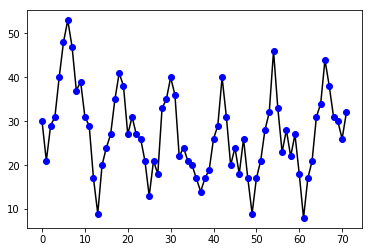

In [16]:
plt.plot(series, 'k', series, 'bo')
plt.show()

You can see that this series is seasonal, there are clearly visible 6 seasons. Although perhaps not easily apparent from the picture, the season length for this series is 12, i.e. it “repeats” every 12 points. In order to apply triple exponential smoothing we need to know what the season length is. (There do exist methods for detecting seasonality in series, but this is way beyond the scope of this text).

#### Initial Trend
For double exponential smoothing we simply used the first two points for the initial trend. With seasonal data we can do better than that, since we can observe many seasons and can extrapolate a better starting trend. The most common practice is to compute the average of trend averages across seasons.

b0=1/L*((yL+1−y1)/L+(yL+2−y2)/L+...+(yL+L−yL)/L)

Good news - this looks simpler in Python than in math notation:

In [17]:
def initial_trend(series, slen):
    sum = 0
    for i in range(slen):
        sum += float(series[i+slen] - series[i])/ slen
    return sum/ slen

### Initial Seasonal Components
The situation is even more complicated when it comes to initial values for the seasonal components. Briefly, we need to compute the average level for every observed season we have, divide every observed value by the average for the season it’s in and finally average each of these numbers across our observed seasons. If you want more detail, here is one thorough description of this process.

I will forgo the math notation for initial seasonal components, but here it is in Python. The result is a season-length array of seasonal components.

In [18]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j + slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j + i] - season_averages[j]
        seasonals[i] = sum_of_vals_over_avg / n_seasons
    return seasonals

In [19]:
initial_seasonal_components(series, 12)

{0: -7.4305555555555545,
 1: -15.097222222222221,
 2: -7.263888888888888,
 3: -5.097222222222222,
 4: 3.402777777777778,
 5: 8.069444444444445,
 6: 16.569444444444446,
 7: 9.736111111111112,
 8: -0.7638888888888887,
 9: 1.902777777777778,
 10: -3.263888888888889,
 11: -0.7638888888888887}

### The Algorithm
And finally, here is the additive Holt-Winters method in Python. The arguments to the function are the series of observed values, the season length, alpha, beta, gamma and the number of points we want forecasted.:


In [24]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series) + n_preds):
        if i == 0: #initial values
           smooth = series[0]
           trend = initial_trend(series, slen)
           result.append(series[0])
           continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val - seasonals[i%slen]) + (1 - alpha)*(smooth + trend)
            trend = beta * (smooth - last_smooth) + (1 - beta)*trend
            seasonals[i%slen] = gamma*(val - smooth) + (1 - gamma)*seasonals[i%slen]
            result.append(smooth + trend + seasonals[i%slen])
    return result

In [26]:
prediction = triple_exponential_smoothing(series, 12, 0.716, 0.029, 0.993, 24)

In [32]:
len(series)

72

In [33]:
len(prediction)

96

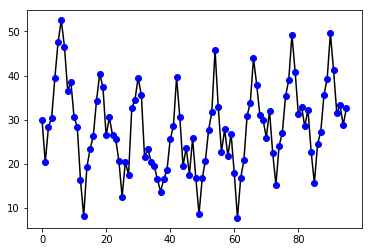

In [27]:
plt.plot(prediction, 'k', prediction, 'bo')
plt.show()